<a href="https://colab.research.google.com/github/sh3986/kaggle/blob/main/project/4RL_Challenge_FlappyBird_target_net2_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Challenge : FlappyBird

In [1]:
!pip install pygame munch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.2 MB/s 


### Google Drive 연동
구글 드라이브에 본 프로젝트 폴더를 저장한 후, 구글드라이브를 마운트


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/project_4_RL/RL_Challenge')  # 본 프로젝트 폴더 주소를 입력

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Kaggle/project_4_RL/RL_Challenge

/content/gdrive/MyDrive/Colab Notebooks/Kaggle/project_4_RL/RL_Challenge


In [5]:
import os
import sys
import time
import random
import argparse
from glob import glob
from collections import deque

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

from game import Game
from utils import init_weights
from munch import Munch

pygame 2.1.2 (SDL 2.0.16, Python 3.7.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
args = {
    "game": "flappy",
    "gamma": 0.99,
    "initial_epsilon": 0.2,
    "final_epsilon":1e-4,
    "iteration": 5000000,
    "lr": 1e-4,
    "use_pretrained": False,
    "tag": "dqn_target_net_7",
    "writer": "writer",
    "batch_size" : 64,
    "memory_size": 50000,
    "update_interval":10
}
args = Munch(args)
args.writer = SummaryWriter(os.path.join('ckpt', args.tag))

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print('GPU Enabled: {}'.format(torch.cuda.is_available()))

GPU Enabled: True


###*DQN* class 정의

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    def __init__(self, channel_in=1):
        super(DQN, self).__init__()
        self.number_of_actions = 2

        # 1, 1, 84, 84
        self.conv1 = nn.Conv2d(channel_in, 32, kernel_size = 8, stride = 4)
        # 1, 32, 20, 20
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        # 1, 64, 9, 9
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        # 1, 64, 7, 7
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, self.number_of_actions)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)


In [152]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.number_of_actions = 2

        self.fc1 = nn.Linear(7, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, self.number_of_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [153]:
import collections
import random

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=args.memory_size)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self):
        mini_batch = random.sample(self.buffer,  min(len(self.buffer), args.batch_size))
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_lst.append(done)

        return torch.cat(tuple(s for s in s_lst)), \
                torch.cat(tuple(a for a in a_lst)), \
                torch.cat(tuple(r for r in r_lst)), \
                torch.cat(tuple(s_prime for s_prime in s_prime_lst)), \
                torch.cat(tuple(done for done in done_lst))

    def flush(self, size=1):
        for _ in range(size):
            self.buffer.popleft()

    def size(self):
        return len(self.buffer)
    
    def isfull(self):
        return len(self.buffer) == args.memory_size

### 모델 초기화

In [309]:
def get_state(image):
    ima_gray = cv2.cvtColor(cv2.resize(image, (288, 288)), cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(ima_gray, 110, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    pos_list = []
    area_list = []
    flappy_list =[]
    for c in contours:
        mmt = cv2.moments(c)
        if mmt['m00'] == 0:
            continue
        # m10/m00, m01/m00 중심점 계산
        cx = int(mmt['m10']/mmt['m00'])
        cy = int(mmt['m01']/mmt['m00'])

        # 영역 넓이
        a = mmt['m00']
        if ((a > 210) & (a < 530)) | ((a > 15933.00) & (a < 18933.00)):
            pos_list.append((cx, cy))
            area_list.append(a)

        if ((a > 5) & (a < 20)):
            flappy_list.append((cx, cy))

    flappy = [0, 0]
    for f in flappy_list:
        flappy[0] += f[0]
        flappy[1] += f[1]

    flappy = np.array(flappy)/len(flappy_list)

    floor_index = np.argsort(area_list)[-1]
    floor = pos_list[floor_index]
    del pos_list[floor_index]

    def calculate_distance(obj1, obj2):
        dist = np.sqrt((obj1[0] - obj2[0])**2 + (obj1[1] - obj2[1])**2)
        return dist

    dist_list = []
    for i in range(len(pos_list)):
        d = calculate_distance(flappy, pos_list[i])
        if d > 50:
            dist_list.append(d)

    up_pipe = None
    down_pipe = None
    obj_idx = np.argsort(dist_list)[:2]
    obj1 = pos_list[obj_idx[0]]
    obj2 = pos_list[obj_idx[1]]

    if obj1[0] < obj2[0]:
        up_pipe, down_pipe = obj1, obj2
    else:
        down_pipe, up_pipe = obj1, obj2
    
    def get_h_dist(obj1, obj2):
        return np.abs(obj1[0] - obj2[0])

    def get_v_dist(obj1, obj2):
        return np.abs(obj1[1] - obj2[1])

    state = list(flappy) + [get_h_dist(flappy, up_pipe), get_v_dist(flappy, up_pipe), get_h_dist(flappy, down_pipe), get_v_dist(flappy, down_pipe), get_h_dist(flappy, floor)]
    state = torch.from_numpy(np.array([state], dtype=np.float32)).cuda()
    return state

In [310]:
model = DQN()
# model_target = DQN()
# model_target.load_state_dict(model.state_dict())

if args.use_pretrained:
    model = torch.load(
        sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1]
    )
else:
    os.makedirs(os.path.join('ckpt', args.tag), exist_ok = True)
    model.apply(init_weights)

model = model.cuda()
# model_target = model_target.cuda()
start = time.time()

episode = 0
iteration = 0

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# instantiate game
memory = ReplayBuffer()
game = Game(game=args.game)
high_total_reward = 0

elapsed_time = 0
action = torch.zeros([model.number_of_actions], dtype=torch.float32)
total_reward = game.reward
terminal = game.game_over()

# image_data = game.get_torch_image().cuda()
# state = image_data.unsqueeze(0)
# image_frame = game.get_torch_image().numpy()
# image_data = np.stack((image_frame,image_frame,image_frame,image_frame),axis=1)
# state = torch.from_numpy(image_data).cuda()
state = get_state(game.get_image()).cuda()

start = time.time()

### Debug

In [311]:
state.shape

torch.Size([1, 7])

In [290]:
image = cv2.resize(game.get_image(), (288, 288))

In [291]:
ima_gray = cv2.cvtColor(cv2.resize(image, (288, 288)), cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(ima_gray, 110, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

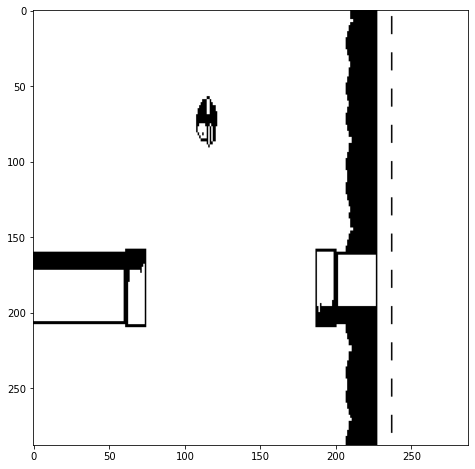

In [292]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(thresh,'gray')

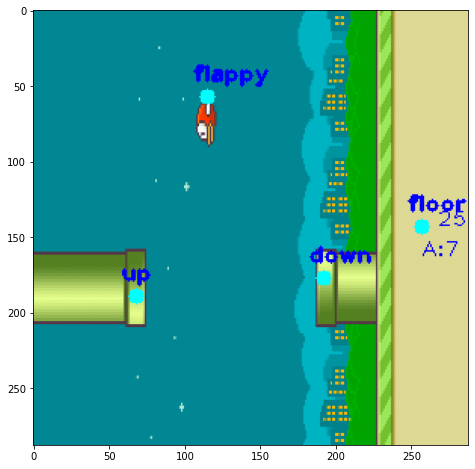

In [308]:
image_copy = image.copy()

pos_list = []
area_list = []
flappy_list =[]
for c in contours:
    mmt = cv2.moments(c)
    if mmt['m00'] == 0:
        continue
    # m10/m00, m01/m00 중심점 계산
    cx = int(mmt['m10']/mmt['m00'])
    cy = int(mmt['m01']/mmt['m00'])

    # 영역 넓이
    a = mmt['m00']
    if ((a > 5) & (a < 20)):
        flappy_list.append((cx, cy))

flappy = [0, 0]
for f in flappy_list:
    flappy[0] += f[0]
    flappy[1] += f[1]

flappy = np.array(flappy)/len(flappy_list)

for c in contours:
    mmt = cv2.moments(c)
    if mmt['m00'] == 0:
        continue
    # m10/m00, m01/m00 중심점 계산
    cx = int(mmt['m10']/mmt['m00'])
    cy = int(mmt['m01']/mmt['m00'])

    # 영역 넓이
    a = mmt['m00']
    
    if ((a > 210) & (a < 530)) | ((a > 15933.00) & (a < 18933.00)):
        pos_list.append((cx, cy))
        area_list.append(a)
        # # 영역 외곽선 길이
        # l = cv2.arcLength(c, True)

        # # 중심점에 노란색 점 그리기
        # cv2.circle(image_copy, (cx, cy), 5, (0, 255, 255), -1)

        # # 중심점 근처에 넓이 그리기
        # cv2.putText(image_copy, "A:{:0.0f}".format(a), (cx, cy+20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))
        # # cv2.putText(image_copy, "{:0.0f}, {:0.0f}".format(cx, cy), (cx+10, cy), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))

        # print('area:{:0.2f}'.format(cv2.contourArea(c, False)))

##################
def calculate_distance(obj1, obj2):
    dist = np.sqrt((obj1[0] - obj2[0])**2 + (obj1[1] - obj2[1])**2)
    return dist

floor_index = np.argsort(area_list)[-1]
floor = pos_list[floor_index]
del pos_list[floor_index]

dist_list = []
for i in range(len(pos_list)):
    d = calculate_distance(flappy, pos_list[i])
    if d > 50:
        dist_list.append(d)

up_pipe = None
down_pipe = None
obj_idx = np.argsort(dist_list)[:2]
obj1 = pos_list[obj_idx[0]]
obj2 = pos_list[obj_idx[1]]

if obj1[0] < obj2[0]:
    up_pipe, down_pipe = obj1, obj2
else:
    down_pipe, up_pipe = obj1, obj2

label = ['flappy', 'up', 'down', 'floor']
for i, obj in enumerate([flappy, up_pipe, down_pipe, floor]):
    cx = int(obj[0])
    cy = int(obj[1])
    cv2.circle(image_copy, (cx, cy), 5, (0, 255, 255), -1)
    cv2.putText(image_copy, label[i], (cx-10, cy-10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)

# 중심점에 노란색 점 그리기
cv2.circle(image_copy, (cx, cy), 5, (0, 255, 255), -1)

# 중심점 근처에 넓이 그리기
cv2.putText(image_copy, "A:{:0.0f}".format(a), (cx, cy+20), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))
cv2.putText(image_copy, "{:0.0f}, {:0.0f}".format(cx, cy), (cx+10, cy), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255))

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image_copy)

In [299]:
dist_list = []
for i in range(len(pos_list)):
    d = calculate_distance(flappy, pos_list[i])
    if d > 50:
        dist_list.append(d)

up_pipe = None
down_pipe = None
obj_idx = np.argsort(dist_list)[:2]
obj1 = pos_list[obj_idx[0]]
obj2 = pos_list[obj_idx[1]]

In [301]:
flappy

array([nan, nan])

In [145]:
def get_h_dist(obj1, obj2):
    return np.abs(obj1[0] - obj2[0])

def get_v_dist(obj1, obj2):
    return np.abs(obj1[1] - obj2[1])

get_h_dist(flappy, up_pipe), get_v_dist(flappy, up_pipe), get_h_dist(flappy, down_pipe), get_v_dist(flappy, down_pipe), get_h_dist(flappy, floor)

(19.0, 81.0, 106.0, 81.0, 170.0)

### 강화학습

20점 넘는 state는 그냥 다른 memory에 저장?


In [ ]:
while iteration < args.iteration:
    output = model(state)[0]
    action = torch.zeros([model.number_of_actions], dtype=torch.float32)
    
    # epsilon greedy exploration
    # Pick action --> random or index of maximum q value
    # if total_reward >= 19:
    #     epsilon = args.final_epsilon + ((args.iteration - iteration*0.7) * (args.initial_epsilon - args.final_epsilon) / args.iteration)
    # else:
    epsilon = args.final_epsilon + ((args.iteration - iteration) * (args.initial_epsilon - args.final_epsilon) / args.iteration)

    coin = random.random()
    random_action = coin <= epsilon
    if random_action:
        action_index =  random.randint(0, 1)
    else:
        action_index =  output.argmax().item()


    action[action_index] = 1

    elapsed_time = time.time() - start

    # get next state and reward
    terminal = game.game_over()
    game_reward = game.act(action_index)
    
    # image_data_1 = game.get_torch_image().cuda()
    # state_1 = image_data_1.unsqueeze(0)

    # image_frame_1 = game.get_torch_image().numpy()
    # state_1 = np.append(image_frame_1.reshape(1,1,84,84),state[:, :3, :].cpu(),axis=1)
    # state_1 = torch.from_numpy(state_1).cuda()
    state_1 = get_state(game.get_image()).cuda()

    action = action.unsqueeze(0).cuda()
    reward = torch.from_numpy(np.array([game_reward], dtype=np.float32)).unsqueeze(0).cuda()
    done = torch.from_numpy(np.array([1.0 if terminal else 0.0], dtype=np.float32)).unsqueeze(0).cuda()

    # save transition to replay memory
    memory.put((state, action, reward, state_1, done))
    # if replay memory is full, remove the oldest transition
    if memory.isfull():
        memory.flush()

    #### minibatch Train
    # sample random minibatch
    if terminal:
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = memory.sample()
        s_batch = s_batch.cuda()
        a_batch = a_batch.cuda()
        r_batch = r_batch.cuda()
        s_prime_batch = s_prime_batch.cuda()
        done_batch = done_batch.cuda()

        # get output for the next state
        q_out = model(s_batch)
        q_prime_out = model(s_prime_batch) # q target으로 하도록

        # 종료한 state는 더 이상 미래의 보상이 없으니까 (max Q 구할 필요 없음)
        y_hat = torch.cat(
                    tuple(reward if done else reward + args.gamma * torch.max(prediction) for reward, done, prediction in zip(r_batch, done_batch, q_prime_out))
                )
        y_hat = y_hat.detach()
        q_value = torch.sum(q_out * a_batch, dim=1)
        
        # calculate with target network
        optimizer.zero_grad()
        loss = criterion(q_value, y_hat)

        loss.backward()
        optimizer.step()
        args.writer.add_scalar('Train/loss', loss, iteration)

    state = state_1
    iteration += 1
    total_reward += game.reward

    # if episode%args.update_interval == 0:
    #     model_target.load_state_dict(model.state_dict())


    if terminal:
        args.writer.add_scalar('Episode/elapsed_time', elapsed_time, episode)
        args.writer.add_scalar('Episode/episode', episode, episode)
        args.writer.add_scalar('Episode/total_reward', total_reward, episode)
        
        game.reset_game()
        episode += 1
        start = time.time()
        print('Episode {} (Iteration {}): Agent passed {} pipes!, Time: {:.3f} epsilon: {:.4f} loss: {:.4f}'.format(episode, iteration, total_reward, elapsed_time, epsilon, loss))
        if total_reward > high_total_reward:
            print('Weight Saved!')
            high_total_reward = total_reward
            torch.save(model,
                        os.path.join('ckpt', args.tag, 'E{:07d}_S{:03d}.pth'.format(episode, int(total_reward)))
                        )
        total_reward = 0
        # image_data = game.get_torch_image().cuda()
        # state = image_data.unsqueeze(0)

print("Saving final model")
torch.save(model,
            os.path.join('ckpt', args.tag, 'E_{:07d}_S{:03d}.pth'.format(episode, int(high_total_reward)))
            )

Episode 1 (Iteration 38): Agent passed 0.0 pipes!, Time: 4.327 epsilon: 0.2000 loss: 367.0456
Episode 2 (Iteration 76): Agent passed 0.0 pipes!, Time: 0.121 epsilon: 0.2000 loss: 286.4882
Episode 3 (Iteration 114): Agent passed 0.0 pipes!, Time: 0.122 epsilon: 0.2000 loss: 353.1873
Episode 4 (Iteration 152): Agent passed 0.0 pipes!, Time: 0.115 epsilon: 0.2000 loss: 211.5347
Episode 5 (Iteration 190): Agent passed 0.0 pipes!, Time: 0.126 epsilon: 0.2000 loss: 269.4613
Episode 6 (Iteration 228): Agent passed 0.0 pipes!, Time: 0.113 epsilon: 0.2000 loss: 220.5174
Episode 7 (Iteration 266): Agent passed 0.0 pipes!, Time: 0.118 epsilon: 0.2000 loss: 419.4038
Episode 8 (Iteration 304): Agent passed 0.0 pipes!, Time: 0.133 epsilon: 0.2000 loss: 196.5086
Episode 9 (Iteration 342): Agent passed 0.0 pipes!, Time: 0.123 epsilon: 0.2000 loss: 301.4721
Episode 10 (Iteration 380): Agent passed 0.0 pipes!, Time: 0.121 epsilon: 0.2000 loss: 128.5837
Episode 11 (Iteration 421): Agent passed 0.0 pipes!

### 기존 코드

In [ ]:
import os
import sys
import time
import random
import argparse
from glob import glob
from collections import deque

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import numpy as np

from game import Game
from utils import init_weights
from munch import Munch

def train(args):
    model = DQN()
    if args.use_pretrained:
        model = torch.load(
            sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1]
        )
    else:
        os.makedirs(os.path.join('ckpt', args.tag), exist_ok = True)
        model.apply(init_weights)
    model = model.cuda()
    start = time.time()

    episode = 0
    iteration = 0
    epsilon = args.epsilon

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # instantiate game
    game = Game(game=args.game)
    high_total_reward = 0

    # initialize replay memory
    """
    TO DO

    D =
    """

    elapsed_time = 0
    action = torch.zeros([model.number_of_actions], dtype=torch.float32)
    total_reward = game.reward
    terminal = game.game_over()

    image_data = game.get_torch_image().cuda()
    state = image_data.unsqueeze(0)

    start = time.time()

    while iteration < args.iteration:
        output = model(state)[0]
        action = torch.zeros([model.number_of_actions], dtype=torch.float32)

        # epsilon greedy exploration
        random_action = False
        """
        TO DO

        random_action =
        """

        # Pick action --> random or index of maximum q value
        action_index = 0
        """
        TO DO

        action_index =
        """

        action[action_index] = 1

        elapsed_time = time.time() - start

        # get next state and reward
        reward = game.act(action_index)
        terminal = game.game_over()
        image_data_1 = game.get_torch_image().cuda()

        state_1 = image_data_1.unsqueeze(0)
        action = action.unsqueeze(0).cuda()
        reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0).cuda()

        # save transition to replay memory
        """
        TO DO
        """

        # if replay memory is full, remove the oldest transition
        """
        TO DO
        """

        # sample random minibatch
        """
        TO DO
        """

        # get output for the next state
        output_1 = model(state_1)

        y = reward if terminal else reward + args.gamma * torch.max(output_1)

        # calculate with target network
        q_value = torch.sum(model(state) * action, dim=1)

        optimizer.zero_grad()
        y = y.detach()
        loss = criterion(q_value, y)

        loss.backward()
        optimizer.step()

        state = state_1
        iteration += 1
        total_reward += game.reward

        args.writer.add_scalar('Train/loss', loss, iteration)

        if terminal:
            args.writer.add_scalar('Episode/elapsed_time', elapsed_time, episode)
            args.writer.add_scalar('Episode/episode', episode, episode)
            args.writer.add_scalar('Episode/total_reward', total_reward, episode)
            total_reward = 0
            game.reset_game()
            episode += 1
            start = time.time()
            print('Episode {} (Iteration {}): Agent passed {} pipes!, Time: {:.3f}'.format(episode, iteration, total_reward, elapsed_time))
            if total_reward > high_total_reward:
                print('Weight Saved!')
                high_total_reward = total_reward
                torch.save(model,
                           os.path.join('ckpt', args.tag, 'E{:07d}_S{:03d}.pth'.format(episode, int(total_reward)))
                           )
    print("Saving final model")
    torch.save(model,
               os.path.join('ckpt', args.tag, 'E_{:07d}_S{:03d}.pth'.format(episode, int(high_total_reward)))
               )

In [ ]:
from munch import Munch
#parser = argparse.ArgumentParser(description='Deep Q Learning')
# Simple parser
args = {
    "game": "flappy",
    "gamma": 0.99,
    "epsilon": 0.02,
    "iteration": 1000000,
    "lr": 1e-4,
    "use_pretrained": False,
    "tag": "dqn",
    "writer": "writer"
}
args = Munch(args)

args.writer = SummaryWriter(os.path.join('ckpt', args.tag))

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
print('GPU Enabled: {}'.format(torch.cuda.is_available()))

train(args)


### Test

In [ ]:
import os
import time
import argparse
from glob import glob

import torch

from game import Game
from utils import Recorder

def test(args):
    model = torch.load(
        sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1],
        map_location='cpu'
    ).eval()
    print('Loaded model: {}'.format(sorted(glob(os.path.join('ckpt', args.tag, '*.pth')))[-1]))
    # initialize video writer
    video_filename = 'output_{}.avi'.format(args.tag)

    dict_screen_shape = {
        "flappy":(288, 512),
    }
    out = Recorder(video_filename=video_filename, fps=30,
                   width=dict_screen_shape[args.game][0],
                   height=dict_screen_shape[args.game][1])
    total_reward_list = []
    time_list = []

    rewards = {
        "positive": 1, # when the plasyer pass the pipe
        "tick": 0, # at every tick
        "loss": 0, # when died
    }
    game = Game(seed=args.seed, game=args.game, rewards=rewards)
    for trials in range(10):

        elapsed_Time = 0
        action = torch.zeros([model.number_of_actions], dtype=torch.float32)
        terminal = game.game_over()
        start = time.time()
        total_reward = 0

        image_data = game.get_torch_image()
        state = image_data.unsqueeze(0)
        while not terminal:
            output = model(state)[0]
            action = torch.zeros([model.number_of_actions], dtype=torch.float32)
            action_index = torch.argmax(output)
            total_reward += game.act(action_index)
            terminal = game.game_over()
            image_data_1 = game.get_torch_image()
            state = image_data_1.unsqueeze(0)

            out.write(game.get_image())

        game.reset_game()
        total_reward_list.append(total_reward)
        time_list.append(time.time()-start)
        print('Game Ended!')
        print('Total reward: {} !'.format(total_reward))

    # Add summary
    out.write_score(sum(total_reward_list), sum(time_list))
    out.save()
    print('Cumulated Total Reward: {}'.format(sum(total_reward_list)))
    print('Total Run Time: {:.3f}'.format(sum(time_list)))

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Deep Q Learning')
    parser.add_argument('--seed', default=42, type=int,
                        help='Random seed')
    parser.add_argument('--game', default='flappy', type=str,
                        help='{flappy}')
    parser.add_argument('--tag', default="dqn", type=str,
                        help='name to save')
    args = parser.parse_args()

    test(args)